### Importamos librerías

In [1]:
import pandas as pd
import pyodbc
from tweepy.streaming import StreamListener
from pandas.io import sql
from sqlalchemy import create_engine
from pandas.io.json import json_normalize
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import re
import os
import nltk.stem as stemmers
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
import time
from collections import defaultdict
from nltk.stem import PorterStemmer
from numpy import linalg as la
from array import array
import math
import numpy as np
import collections
import gensim
pd.set_option('display.max_columns', None)
import networkx as nx
#df_tweets, dicoFreq
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import multiprocessing
import sys
import io
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup

## Download the stemmers

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iagon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iagon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Credenciales

In [4]:
'''
aToken =       ""
aTokenSecret = ""
cKey =         ""
cSecret =      ""
'''

'\naToken =       ""\naTokenSecret = ""\ncKey =         ""\ncSecret =      ""\n'

### Twitter Scraping

Abrimos los tweets y los guardamos en dataframes para que durante la práctica sea más fácil trabajar con ellos. Vemos la muestra inicial.

In [6]:
with open("data.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

type(data)

list

In [7]:
df_tweets = pd.DataFrame.from_records(data)

In [8]:
df_tweets

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,withheld_in_countries
0,Sun Nov 29 08:07:17 +0000 2020,1332959303351885824,1332959303351885824,RT @nowthisnews: Every marble is an American w...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 14407756, 'id_str': '14407756', 'name':...",None,None,None,None,{'created_at': 'Sat Nov 28 23:03:00 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...","{'media': [{'id': 1329428173243772931, 'id_str...",False,False,False,low,en,1606637237762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sun Nov 29 08:07:17 +0000 2020,1332959303398006785,1332959303398006785,"RT @Kriseman: COVID has killed nearly 270,000 ...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,"{'id': 2385552397, 'id_str': '2385552397', 'na...",None,None,None,None,{'created_at': 'Sat Nov 28 16:37:29 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,False,NaN,low,en,1606637237773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sun Nov 29 08:07:17 +0000 2020,1332959303360196608,1332959303360196608,"@AthaleLab Hello, here is your unroll: @ewanbi...","<a href=""https://threadreaderapp.com"" rel=""nof...",True,1.332959e+18,1332959284489961472,51128646.0,51128646,AthaleLab,"{'id': 1095406446001369088, 'id_str': '1095406...",None,None,None,None,NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,False,False,False,low,en,1606637237764,"[11, 140]","{'full_text': '@AthaleLab Hello, here is your ...",NaN,NaN,NaN,NaN,NaN
3,Sun Nov 29 08:07:17 +0000 2020,1332959303389618176,1332959303389618176,"Also, anyone can believe this government could...","<a href=""http://twitter.com/download/iphone"" r...",True,NaN,None,NaN,None,None,"{'id': 1444110548, 'id_str': '1444110548', 'na...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,False,False,NaN,low,en,1606637237771,NaN,"{'full_text': 'Also, anyone can believe this g...",1.332776e+18,1332775706175082496,{'created_at': 'Sat Nov 28 19:57:44 +0000 2020...,"{'url': 'https://t.co/TZxbzaCxmf', 'expanded':...",NaN
4,Sun Nov 29 08:07:16 +0000 2020,1332959297001631744,1332959297001631744,RT @Lin_Anderson: THE INNOCENT DEAD ★★★★★ Anot...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,None,"{'id': 827528932383670273, 'id_str': '82752893...",None,None,None,None,{'created_at': 'Tue Nov 24 22:30:13 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,False,NaN,low,en,1606637236248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212972,Fri Dec 11 18:25:41 +0000 2020,1337463583354056706,1337463583354056706,RT @Iam_Afrodisiac: Should’ve been frontline D...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 30398859, 'id_str': '30398859', 'name':...",None,None,None,None,{'created_at': 'Fri Dec 11 04:35:53 +0000 2020...,True,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,False,NaN,low,en,1607711141800,NaN,NaN,1.337244e+18,1337243797466603522,{'created_at': 'Fri Dec 11 03:52:20 +0000 2020...,"{'url': 'https://t.co/2A5KhG4lwY', 'expanded':...",NaN
212973,Fri Dec 11 18:25:41 +0000 2020,1337463583588814849,1337463583588814849,RT @VirusesImmunity: The estimated vaccine eff...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,No

###  Tweets structure

Seguidamente, veremos el número total de tweets, con los tweets únicos que són los que retweets y los twiteros únicos.

In [9]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    retweets_ = df_tweets["retweeted_status"].apply(lambda x: 0 if str(x) == "nan" else 1)
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x: x["id"])
    
    tot_users = len(set(users_))
    
    print("Tot Retweets")
    print(tot_retweets)

    print("Unique Tweets")
    print(unique_tweets)
    
    print("Unique Users")
    print(tot_users)

In [10]:
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

Tot Retweets
125480
Unique Tweets
87497
Unique Users
158014


En la siguiente celda **extraemos los hashtags** para que no interfieran.

In [11]:
def extract_hashtags():
    """
    
    """
    
    hashtags_lists = df_tweets["entities"].apply(lambda x: x["hashtags"])
    
    hashtags = hashtags_lists.apply(lambda x: x[0]["text"].lower() if x != [] else None)
    
    hashtags_by_frequency = Counter(hashtags)
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k != None}
    
    return hashtags_by_frequency

In [12]:
hashtags_lists = df_tweets["entities"].apply(lambda x: x["hashtags"])
hashtags_lists.head(30)

0                                                    []
1                                                    []
2                                                    []
3                                                    []
4                                                    []
5                                                    []
6                                                    []
7                                                    []
8                                                    []
9                                                    []
10                                                   []
11                                                   []
12                                                   []
13                                                   []
14    [{'text': 'FinallyLisaOnPenshoppeTV', 'indices...
15                                                   []
16                                                   []
17                                              

Miramos cual es el **hashtag que tiene más tweets**.

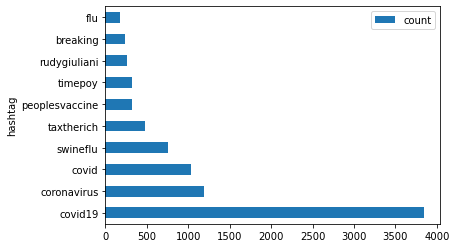

In [13]:
hashtags_by_frequency = extract_hashtags()
#hashtags_by_frequency

df_hashtags = pd.DataFrame(hashtags_by_frequency.items())
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)

df_hashtags.head(10).plot.barh()
plt.show()

### Preprocessing tweets

Limpiamos los tweets estandarizando el texto.

In [14]:
def remove_accents(text):
    if text:
        return " ".join([unidecode.unidecode(word) for word in text.split()])
    
    return ""

def remove_punctuation_marks(text):
    if text:
        return text.translate(str.maketrans('', '', string.punctuation))
        
    return ""

def text_to_lower_case(text):
    if text:
        return text.lower()
    
    return ""

def remove_emojis(text):
    if text:
        return text.encode('ascii', 'ignore').decode('ascii')
    
    return ""

def remove_multiple_whitespaces(text):
    if text:
        return text.replace(" +"," ").strip()
    
    return ""

def remove_text_marks(text):
    if text:
        
        text = re.sub(r"\'", "", text)
        
        
        text = re.sub(r'[\W]', ' ', text)
        
        return text.strip()

    return ""

def split_text_and_numbers(text):
    return text

def remove_alone_numbers(text):
    if text:
        text = re.sub(r"\d", "", text)
        return text
    
    return ""

def clean_text(text):
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_punctuation_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = split_text_and_numbers(text)
    text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    
    return text

In [15]:
df_tweets['text_clean'] = df_tweets.text.apply(lambda text: clean_text(text))

In [16]:
df_tweets[["text", "text_clean"]].tail(1).values

array([['@HouseGOP @RepLizCheney This #UnitedStates Representative cares nothing for Americans Struggling with #covid19. Hea… https://t.co/l2u07hVh4H',
        'housegop replizcheney this unitedstates representative cares nothing for americans struggling with covid hea https t co luhvhh']],
      dtype=object)

Separamos el texto en palabras.

In [17]:
def convert_to_nltk_text(data, text_field):
    # List that will store tokens
    tokens = []
    
    for text in data[text_field].values:
        tokens.extend((text.split(" ")))
    
    # Return nltk.Text object
    return nltk.Text(tokens)

Cogemos los tokens, eliminamos los stopWords y aplicamos stemming. 

In [18]:
def get_tokens(text):
    # Get the tokens
    if isinstance(text, nltk.Text):
        tokens = text.tokens
    else:
        tokens = text.split(" ")
        
    return tokens

def remove_stopwords(text, 
                     language):
    # Import stopwords
    from nltk.corpus import stopwords
    
    # Get stop words for the given language
    stopwords_list = stopwords.words(language)
    stopwords_list.append('rt')
    stopwords_list.append('https')
    # Get the tokens
    tokens = get_tokens(text)
        
    
    cleaned_text = [word for word in tokens if word and word not in stopwords_list]
    
    # Return cleaned text
    if isinstance(text, nltk.Text):
        output = nltk.Text(cleaned_text)
    else:
        output = " ".join(cleaned_text)
    
    return output

def stem_text(text,
              language):
    
    stemmer = stemmers.SnowballStemmer(language)
    
    # Get the tokens
    tokens = get_tokens(text)
    
    
    stemmas = [stemmer.stem(token) for token in tokens if token]
    
    # Return stemmed text
    if isinstance(text, nltk.Text):
        output = nltk.Text(stemmas)
    else:
        output = " ".join(stemmas)
    
    return output

def standardize_text(text,
                     language):
    # Remove the stop words
    standardized_text = remove_stopwords(text, language)
    
    # Stem the text
    standardized_text = stem_text(standardized_text, language)
    
    # Return
    return standardized_text

In [19]:
nltk_text = convert_to_nltk_text(df_tweets, "text_clean")
standardized_nltk_text = standardize_text(nltk_text, "english")
df_tweets['standardized_text'] = df_tweets.text_clean.apply(lambda text: standardize_text(text, "english"))

Calculamos las **frecuencias de las palabras** dentro de todos los tweets.

In [20]:
dicoFreq = dict(nltk.FreqDist(standardized_nltk_text))


{'co': 75472,
 'covid': 58209,
 'vaccin': 32746,
 'pandem': 18704,
 'peopl': 15725,
 'dead': 15658,
 'get': 14155,
 'death': 9827,
 'year': 9674,
 'new': 9394}

In [ ]:
dicoFreq = dict(nltk.FreqDist(standardized_nltk_text).most_common(10))

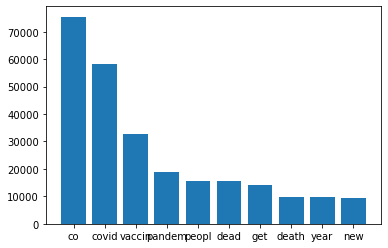

In [21]:
plt.bar(*zip(*dicoFreq.items()))
plt.show()

Plotemos el wordCloud.

In [22]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

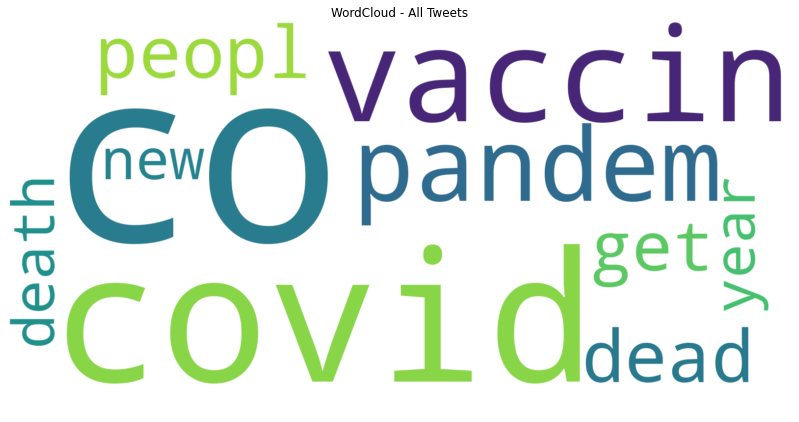

In [23]:
plot_wordcloud("WordCloud - All Tweets", dicoFreq)

Finalmente mostramos el dataframe resultante.

In [24]:
df_tweets.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,withheld_in_countries,text_clean,standardized_text
0,Sun Nov 29 08:07:17 +0000 2020,1332959303351885824,1332959303351885824,RT @nowthisnews: Every marble is an American w...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,"{'id': 14407756, 'id_str': '14407756', 'name':...",None,None,None,None,{'created_at': 'Sat Nov 28 23:03:00 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...","{'media': [{'id': 1329428173243772931, 'id_str...",False,False,False,low,en,1606637237762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt nowthisnews every marble is an american who...,nowthisnew everi marbl american die covid seco...
1,Sun Nov 29 08:07:17 +0000 2020,1332959303398006785,1332959303398006785,"RT @Kriseman: COVID has killed nearly 270,000 ...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,"{'id': 2385552397, 'id_str': '2385552397', 'na...",None,None,None,None,{'created_at': 'Sat Nov 28 16:37:29 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,False,NaN,low,en,1606637237773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt kriseman covid has killed nearly american...,kriseman covid kill near american that equal p...
2,Sun Nov 29 08:07:17 +0000 2020,1332959303360196608,1332959303360196608,"@AthaleLab Hello, here is your unroll: @ewanbi...","<a href=""https://threadreaderapp.com"" rel=""nof...",True,1.332959e+18,1332959284489961472,51128646.0,51128646,AthaleLab,"{'id': 1095406446001369088, 'id_str': '1095406...",None,None,None,None,NaN,False,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,False,False,False,low,en,1606637237764,"[11, 140]","{'full_text': '@AthaleLab Hello, here is your ...",NaN,NaN,NaN,NaN,NaN,athalelab hello here is your unroll ewanbirney...,athalelab hello unrol ewanbirney perspect covi...
3,Sun Nov 29 08:07:17 +0000 2020,1332959303389618176,1332959303389618176,"Also, anyone can believe this government could...","<a href=""http://twitter.com/download/iphone"" r...",True,NaN,None,NaN,None,None,"{'id': 1444110548, 'id_str': '1444110548', 'na...",None,None,None,None,NaN,True,0,0,0,0,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,False,False,NaN,low,en,1606637237771,NaN,"{'full_text': 'Also, anyone can believe this g...",1.332776e+18,1332775706175082496,{'created_at': 'Sat Nov 28 19:57:44 +0000 2020...,"{'url': 'https://t.co/TZxbzaCxmf', 'expanded':...",NaN,also anyone can believe this government could ...,also anyon believ govern could success pull se...
4,Sun Nov 29 08:07:16 +0000 2020,1332959297001631744,1332959297001631744,RT @Lin_Anderson: THE INNOCENT DEAD ★★★★★ Anot...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,None,"{'id': 827528932383670273, 'id_str': '82752893...",None,None,None,None,{'created_at': 'Tue Nov 24 22:30:13 +0000 2020...,False,0,0,0,0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,False,NaN,low,en,1606637236248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt linanderson the innocent dead another brill...,linanderson innoc dead anoth brilliant mysteri...


# 1st RQ - Output analysis (lo necesitamos para el 2nd RQ)

### Inverted - Index

Generamos el inverted - index para poder asignar un rango.

In [25]:
def getTerms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
        
    stemming = PorterStemmer()
    #print(stemming)
    stops = set(stopwords.words("english"))
    ## START CODE
    line= line.lower() ## Transform in lowercase
    line= line.split() ## Tokenize the text to get a list of terms
    line=[w for w in line if w not in stops]  ##eliminate the stopwords (HINT: use List Comprehension)
    line=[stemming.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line

In [26]:
def create_index_tfidf(lines, numDocuments):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    numDocuments -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
        
    index=defaultdict(list)
    tf=defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    titleIndex=defaultdict(str)
    idf=defaultdict(float)
    page_id = -1
    
    for line in lines:
        #line_arr = line.split(" ")
        #print(line_arr[0])
        page_id += 1
        terms = getTerms(''.join(line)) #page_title + page_text
        title = line         
        titleIndex[page_id]=title          
        
        ## ===============================================================        
        ## create the index for the *current page* and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ...,‘termn’: [currentdoc, [list of positions]]}
        
        ## Example: if the curr_doc has id 1 and his text is 
        ## "web retrieval information retrieval":
        
        ## termdictPage ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}
        
        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        termdictPage={}

        for position, term in enumerate(terms): ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            # you can use it to inferr the frequency of current term.
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)


        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term]+=1  # increment df for current term
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
    # Compute idf following the formula (3) above. HINT: use np.log
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])),4)

    return index, tf, df, idf, titleIndex

In [27]:
start_time = time.time()
numDocuments = len(df_tweets)
index, tf, df, idf, titleIndex = create_index_tfidf(df_tweets['standardized_text'],numDocuments )
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 653.29 seconds


In [28]:
print("First 10 Index results for the term 'coronaviru': \n{}".format(index['coronaviru'][:10]))

First 10 Index results for the term 'coronaviru': 
[[7, array('I', [1])], [10, array('I', [3])], [24, array('I', [1])], [38, array('I', [8])], [55, array('I', [9])], [59, array('I', [7])], [63, array('I', [1])], [68, array('I', [4])], [74, array('I', [11])], [89, array('I', [0])]]


### Search with ranking

Utizamos el tf-idf score.

In [29]:
def rankDocuments(terms, docs, index, idf, tf, titleIndex):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for queryVector
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]= query_terms_count[term] / query_norm * idf[term]  

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            
            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # TODO: check if multiply for idf

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [30]:
def search_tf_idf(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs|= set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, titleIndex)   
    return ranked_docs

In [32]:
print("Insert your query:\n")
query = input()   
ranked_docs = search_tf_idf(query, index)    
top = 20

print("\nSample of {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top] :
    lista = []
    if len(df_tweets['entities'][d_id]['hashtags'])>0:
        for hasht in range(len(df_tweets['entities'][d_id]['hashtags'])):
            lista.append(df_tweets['entities'][d_id]['hashtags'][hasht]['text'])
    if len(df_tweets['entities'][d_id]['urls']) > 0:
        print("tweet= {} - Username: {} - Date: {} - Hashtags: {} - Likes: {} - Retweets: {} - Url: {} \n".format(df_tweets['text'][d_id]
                                            , df_tweets['user'][d_id]['screen_name']
                                            ,df_tweets['created_at'][d_id]
                                            , lista
                                            , df_tweets['favorite_count'][d_id]
                                            , df_tweets['retweet_count'][d_id]
                                            , df_tweets['entities'][d_id]['urls'][0]['url']))
    else:
        print("tweet= {} - Username: {} - Date: {} - Hashtags: {} - Likes: {} - Retweets: {} \n".format(df_tweets['text'][d_id]
                                            , df_tweets['user'][d_id]['screen_name']
                                            ,df_tweets['created_at'][d_id]
                                            , lista 
                                            , df_tweets['favorite_count'][d_id]
                                            , df_tweets['retweet_count'][d_id]
                                            ))

Insert your query:

covid

Sample of 20 results out of 56820 for the seached query:

tweet= covid 😭 - Username: pinchelindseyy - Date: Fri Dec 11 18:23:50 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= Because of covid - Username: ThatsJDP - Date: Fri Dec 11 18:23:14 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= no i do not have covid - Username: mangogurI - Date: Fri Dec 11 18:19:37 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= what about covid????? - Username: wajidraja55 - Date: Fri Dec 11 18:18:48 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= Covid 19 - Username: Antwone1600 - Date: Fri Dec 11 18:15:03 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= Covid * - Username: Mooseloversuza1 - Date: Fri Dec 11 18:09:51 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= Covid - Username: ilteri46009471 - Date: Fri Dec 11 18:09:50 +0000 2020 - Hashtags: [] - Likes: 0 - Retweets: 0 

tweet= Covid - Username: JBRIDGEY